# Data Exploration

In this notebook, we load the KITTI dataset and explore the data.

In [2]:
# Import statements.
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from typing import Dict, Any, List, Optional, Tuple
from math import sin, cos

In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/leo/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [59]:
# Global constants.
KITTI_ROOT_DIR = os.path.join('..', 'data', 'KITTI')
LEFT_CAM_ROOT_DIR = os.path.join(KITTI_ROOT_DIR, 'data_object_image_2')
TRAIN_IMAGE_DIR = os.path.join(LEFT_CAM_ROOT_DIR, 'training', 'image_2')
TEST_IMAGE_DIR = os.path.join(LEFT_CAM_ROOT_DIR, 'testing', 'image_2')
LABEL_DIR = os.path.join(KITTI_ROOT_DIR, 'training', 'label_2')
TRAIN_CALIB_DIR = os.path.join(KITTI_ROOT_DIR, 'data_object_calib', 'training',
                              'calib')
TEST_CALIB_DIR = os.path.join(KITTI_ROOT_DIR, 'data_object_calib', 'testing',
                              'calib')
PREDICTION_2D_BOX_DIR = os.path.join('..', 'data', 'predictions', '2d_boxes',
                                     'train')
PREDICTION_3D_BOX_DIR = os.path.join('..', 'data', 'predictions', '3d_boxes',
                                     'train')
PROJ_MTX_SHAPE = (3, 4)
DEFAULT_DATASET_ARGS = {'val_split': 0.3}
TRAIN_KEY = 'train'
VAL_KEY = 'val'
TEST_KEY = 'test'
# The 4 rows are, respectively: front, left, back, and right.
FACE_IDX = np.array([[0, 1, 5, 4],
                     [1, 2, 6, 5],
                     [2, 3, 7, 6],
                     [3, 0, 4, 7]])
# Occlusion is represented as an int in the interval [0, 4].
# The occlusion code is used as an index to get the color.
# Green: not occluded.
# Yellow: partly occluded.
# Red: fully occluded.
# White: unknown.
OCCLUSION_COLORS = ['green', 'yellow', 'red', 'white']

In [4]:
def get_partition(train_image_dir: str,
                  test_image_dir: str, dataset_args: Dict[str, Any] =
                  DEFAULT_DATASET_ARGS) -> Dict[str,List[str]]:
    """Returns a dict where the keys are 'train', 'test', and 'val', and the
    values are the images under each. The list is the authoratative order of the
    train/test examples; partition['train'][0] is the first training example,
    and x_train[0] will correspond with that filename.
    :param train_image_dir: The directory in which are located all the training
    images.
    :param test_image_dir: The directory in which are located all the test
    images.
    :param dataset_args: The dataset arguments. See DEFAULT_DATASET_ARGS for
    available options.
    :return: The train/val/test partition.
    """
    dataset_args = {**DEFAULT_DATASET_ARGS, **dataset_args}
    partition = {}
    train_image_filenames = [filename for
                             filename in os.listdir(train_image_dir) if
                             filename.endswith('.png')]
    rand_indices = np.random.permutation(len(train_image_filenames))
    split_index = int(dataset_args['val_split'] * len(train_image_filenames))
    val_indices = rand_indices[:split_index]
    train_indices = rand_indices[split_index:]
    partition[TRAIN_KEY] = [train_image_filenames[i] for i in train_indices]
    partition[VAL_KEY] = [train_image_filenames[i] for i in val_indices]
    test_image_filenames = [filename for
                            filename in os.listdir(test_image_dir) if
                            filename.endswith('.png')]
    partition[TEST_KEY] = test_image_filenames
    return partition

In [5]:
def load_image_into_numpy_array(
    path: str,
    target_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """Load an image from file into a numpy array.
    :param path: The path to the image.
    :param target_size: If specified, the width and height of the output array.
    If None, the image is size is unchanged.
    :return: The image contents as an np.ndarray of type uint8.
    """
    img_data = cv2.imread(path)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    if target_size:
        img_data = cv2.resize(img_data, target_size)
    return img_data.astype(np.uint8)

In [6]:
def display_image(filename: str,
                  fig_size: Tuple[float, float] = (9.0, 2.75)) -> None:
    """Displays the image at filename.
    :param filename: The path to the image.
    :param fig_size: The size of the output, in inches. The default values will
    show the KITTI images in the correct aspect ratio without passing the 80
    character vertical margin in jupyter.
    """
    img = load_image_into_numpy_array(filename)
    plt.imshow(img)
    fig = plt.gcf()
    fig.set_size_inches(*fig_size)
    plt.tight_layout()
    plt.xlim((0, img.shape[1]))
    plt.ylim((img.shape[0], 0))

In [56]:
def display_image_2d_boxes(filename: str,
                           image_labels: List[str],
                           fig_size: Tuple[float, float] = (9.0, 2.75),
                           force_box_color: Optional[str] = None) -> None:
    """Displays the image at filename with its 2D bounding boxes.
    :param filename: The path to the image.
    :param image_labels: The image's labels.
    :param fig_size: The size of the output, in inches.
    :param force_box_color: If specified, all boxes will be of this color. Used
    mainly for predictions, in which no occlusion information is computed.
    """
    display_image(filename, fig_size=fig_size)
    ax = plt.gca()
    for line in image_labels:
        obj = get_label_obj(line)
        width = obj['x2'] - obj['x1']
        height = obj['y2'] - obj['y1']
        color = force_box_color if force_box_color else \
            OCCLUSION_COLORS[obj['occlusion']]
        linestyle = '-' if obj['truncation'] <= 0.1 else '--'
        rect = patches.Rectangle((obj['x1'], obj['y1']), width, height,
                                 linewidth=3, edgecolor=color,
                                 facecolor='none', linestyle=linestyle)
        ax.add_patch(rect)

In [55]:
def display_image_3d_boxes(filename: str,
                           image_labels: List[str],
                           image_calib: List[str],
                           fig_size: Tuple[float, float] = (9.0, 2.75),
                           force_box_color: Optional[str] = None) -> None:
    """Displays the image at filename with its 3D bounding boxes.
    :param filename: The path to the image.
    :param image_labels: The image's labels.
    :param image_calib: The image's calibration.
    :param fig_size: The size of the output, in inches.
    :param force_box_color: If specified, all boxes will be of this color. Used
    mainly for predictions, in which no occlusion information is computed.
    """
    display_image(filename, fig_size=fig_size)
    ax = plt.gca()
    P2 = get_projection_matrix(image_calib)
    for line in image_labels:
        obj = get_label_obj(line)
        corners = compute_box_3d(obj, P2)
        orientation = compute_orientation_3d(obj, P2)
        if corners is not None and orientation is not None:
            color = force_box_color if force_box_color else \
                OCCLUSION_COLORS[obj['occlusion']]
            linestyle = '-' if obj['truncation'] <= 0.1 else '--'
            for face in range(4):
                ax.plot(corners[0, FACE_IDX[face, :]],
                        corners[1, FACE_IDX[face, :]],
                        linewidth=3,
                        color=color,
                        linestyle=linestyle)
            ax.plot(orientation[0, :], orientation[1, :], color='white',
                    linewidth=4)
            ax.plot(orientation[0, :], orientation[1, :], color='black',
                    linewidth=2)

In [9]:
def get_projection_matrix(image_calib: List[str]) -> np.ndarray:
    """Returns the projection matrix (P2 for the left monocular camera) listed
    in the calibration file.
    :param image_calib: The image's calibration.
    :return: The projection matrix, P2.
    """
    # Example P2 entry.
    # P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 ...
    for line in image_calib:
        if line.startswith('P2:'):
            nums = line.split(' ')[1:]
            P2 = np.array([float(num) for num in nums])
            return np.reshape(P2, PROJ_MTX_SHAPE)
    raise ValueError('Could not find an entry for P2 in calibration.')

In [10]:
def get_label_obj(label_line: str) -> Dict[str, Any]:
    """Returns a dict with all of the label properties.
    :param label_line: A line from a label file.
    :return: A dict representing the label.
    """
    label_arr = label_line.split(' ')
    obj = {}
    obj['type'] = label_arr[0]
    obj['truncation'] = float(label_arr[1])
    obj['occlusion'] = int(label_arr[2])
    obj['alpha'] = float(label_arr[3])
    obj['x1'] = float(label_arr[4])
    obj['y1'] = float(label_arr[5])
    obj['x2'] = float(label_arr[6])
    obj['y2'] = float(label_arr[7])
    obj['height'] = float(label_arr[8])
    obj['width'] = float(label_arr[9])
    obj['length'] = float(label_arr[10])
    obj['tx'] = float(label_arr[11])
    obj['ty'] = float(label_arr[12])
    obj['tz'] = float(label_arr[13])
    obj['ry'] = float(label_arr[14])
    return obj

In [11]:
def project_to_image(pts_3d: np.ndarray, P: np.ndarray) -> np.ndarray:
    """Projects the 3D points into 2D using the projection matrix P.
    :param pts_3d: The 3D points as a 3 x n matrix.
    :param P: The projection matrix, of shape PROJ_MTX_SHAPE (i.e., 3 x 4).
    :return: The 2D points as a 2 x n matrix.
    """
    # Project in image.
    pts_3d_ones = np.concatenate((pts_3d, np.ones((1, pts_3d.shape[1]))),
                                 axis=0)
    pts_2d = np.matmul(P, pts_3d_ones)
    # Scale projected points.
    pts_2d[0, :] = pts_2d[0, :] / pts_2d[2, :]
    pts_2d[1, :] = pts_2d[1, :] / pts_2d[2, :]
    pts_2d = pts_2d[:2, :]
    return pts_2d    

In [54]:
def compute_box_3d(obj: Dict[str, Any], P: np.ndarray) -> Optional[np.ndarray]:
    """Returns the 2D corners representing the object's 3D bounding box.
    :param obj: The label object.
    :param P: The projection matrix, of shape PROJ_MTX_SHAPE (i.e., 3 x 4).
    :return: The 2D corners of the object's 3D bounding box, of shape 2 x 8, or
    None if the bounding box is not in front of the camera.
    """
    # Rotation matrix around yaw axis.
    R = [[+cos(obj['ry']), 0, +sin(obj['ry'])],
         [0, 1, 0],
         [-sin(obj['ry']), 0, +cos(obj['ry'])]]
    R = np.array(R)
    # 3D bounding box dimensions and corners.
    l = obj['length']
    w = obj['width']
    h = obj['height']
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]
    corners_centered = np.array([x_corners, y_corners, z_corners])
    # Rotate and translate 3D bounding box.
    corners_3d = np.matmul(R, corners_centered)
    corners_3d[0, :] = corners_3d[0, :] + obj['tx']
    corners_3d[1, :] = corners_3d[1, :] + obj['ty']
    corners_3d[2, :] = corners_3d[2, :] + obj['tz']
    # Only draw 3D bounding box for objects in front of the camera.
    if np.any(corners_3d[2, :] < 0.1):
        return None
    # Project the 3D bounding box into the image plane.
    corners_2d = project_to_image(corners_3d, P)
    return corners_2d

In [13]:
def compute_orientation_3d(obj: Dict[str, Any], P: np.ndarray) -> \
    Optional[np.ndarray]:
    """Returns the 2D points representing the object's orientation.
    :param obj: The label object.
    :param P: The projection matrix, of shape PROJ_MTX_SHAPE (i.e., 3 x 4).
    :return: The 2D points representing the object's orientation, of shape
    2 x 2, or None if the object is not in front of the camera.
    """
    # Rotation matrix around yaw axis.
    R = [[+cos(obj['ry']), 0, +sin(obj['ry'])],
         [0, 1, 0],
         [-sin(obj['ry']), 0, +cos(obj['ry'])]]
    R = np.array(R)
    # Orientation in object coordinate system.
    orientation_3d = [[0.0, obj['length']],
                      [0.0, 0.0],
                      [0.0, 0.0]]
    orientation_3d = np.array(orientation_3d)
    # Rotate and translate orientation vector.
    orientation_3d = np.matmul(R, orientation_3d)
    orientation_3d[0, :] = orientation_3d[0, :] + obj['tx']
    orientation_3d[1, :] = orientation_3d[1, :] + obj['ty']
    orientation_3d[2, :] = orientation_3d[2, :] + obj['tz']
    # Only draw orientation for objects in front of the camera.
    if np.any(orientation_3d[2, :] < 0.1):
        return None
    # Project the 3D orientation vector into the image plane.
    orientation_2d = project_to_image(orientation_3d, P)
    return orientation_2d

In [14]:
def get_labels(label_dir: str) -> Dict[str, List[str]]:
    """Returns a dict where the keys are the image filenames and the values are
    the labels. Each file has several labels, each of which represents an
    object.
    :param label_dir: The directory containing the ground truth label files.
    :return: The label dict.
    """
    labels = {}
    label_filenames = [filename for filename in os.listdir(label_dir) if
                       filename.endswith('.txt')]
    for filename in label_filenames:
        with open(os.path.join(label_dir, filename), 'r') as infile:
            labels[filename.replace('.txt', '.png')] = \
                [line.strip() for line in infile.readlines()]
    return labels

In [15]:
def get_calibrations(calib_dir: str) -> Dict[str, List[str]]:
    """Returns a dict where the keys are the image filenames and the values are
    the calibrations. Each file has several calibration entries. There are
    separate calibration directories for both train and test.
    :param calib_dir: The directory containing the calibration files.
    :return: The calibration dict.
    """
    calibrations = {}
    calib_filenames = [filename for filename in os.listdir(calib_dir) if
                       filename.endswith('.txt')]
    for filename in calib_filenames:
        with open(os.path.join(calib_dir, filename), 'r') as infile:
            calibrations[filename.replace('.txt', '.png')] = \
                [line.strip() for line in infile.readlines()]
    return calibrations

In [16]:
partition = get_partition(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR)
labels = get_labels(LABEL_DIR)
train_calibrations = get_calibrations(TRAIN_CALIB_DIR)
test_calibrations = get_calibrations(TEST_CALIB_DIR)
print('{0} train images'.format(len(partition[TRAIN_KEY])))
print('{0} val images'.format(len(partition[VAL_KEY])))
print('{0} test images'.format(len(partition[TEST_KEY])))
print('{0} labels'.format(len(labels.keys())))

5237 train images
2244 val images
7518 test images
7481 labels


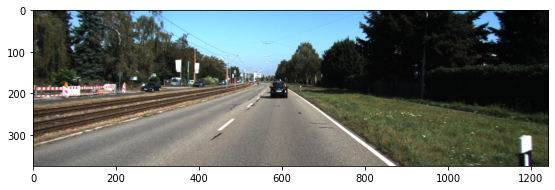

In [17]:
display_image(os.path.join(TRAIN_IMAGE_DIR, partition[TRAIN_KEY][0]))

Labels:
Car 0.88 3 -0.69 0.00 192.37 402.31 374.00 1.60 1.57 3.23 -2.70 1.74 3.68 -1.29
Car 0.00 1 2.04 334.85 178.94 624.50 372.04 1.57 1.50 3.68 -1.17 1.65 7.86 1.90
Car 0.34 3 -1.84 937.29 197.39 1241.00 374.00 1.39 1.44 3.08 3.81 1.64 6.15 -1.31
Car 0.00 1 -1.33 597.59 176.18 720.90 261.14 1.47 1.60 3.66 1.07 1.55 14.44 -1.25
Car 0.00 0 1.74 741.18 168.83 792.25 208.43 1.70 1.63 4.08 7.24 1.55 33.20 1.95
Car 0.00 0 -1.65 884.52 178.31 956.41 240.18 1.59 1.59 2.47 8.48 1.75 19.96 -1.25
DontCare -1 -1 -10 800.38 163.67 825.45 184.07 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 859.58 172.34 886.26 194.51 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 801.81 163.96 825.20 183.59 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 826.87 162.28 845.84 178.86 -1 -1 -1 -1000 -1000 -1000 -10


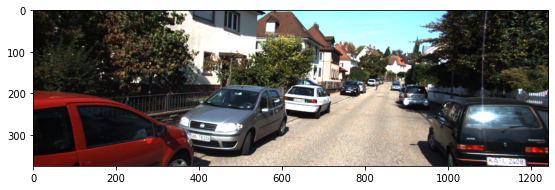

In [18]:
# Use image 0000008.png for consistency (partition is in random order).
example_filename = '000008.png'
display_image(os.path.join(TRAIN_IMAGE_DIR, example_filename))
print('Labels:')
for label in labels[example_filename]:
    print(label)

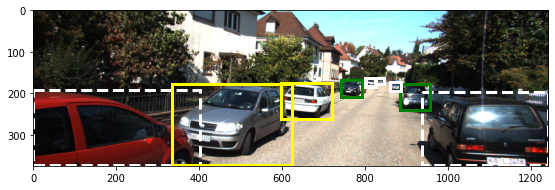

In [19]:
display_image_2d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename),
                      labels[example_filename])

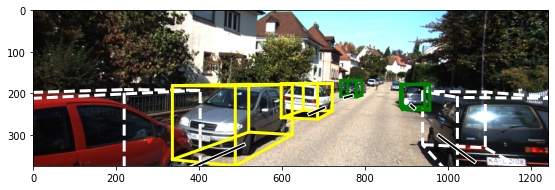

In [20]:
display_image_3d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename),
                      labels[example_filename],
                      train_calibrations[example_filename])

Car -1 -1 -1.5425340654936175 888 181 953 236 1.4571902084915351 1.5694623284698868 3.445788966618576 8.48 1.75 19.96 -1.1407907309025835 0.6358587741851807 0.79068303
Car -1 -1 1.842237607636724 747 169 804 206 1.4474181610910606 1.7471524991752052 3.953574793540039 7.24 1.55 33.2 2.05694845364957 0.6719390749931335 0.6925454
Car -1 -1 -1.9013878564026694 915 197 1232 375 1.5597922283975791 1.4476683282019043 3.931476907931366 3.81 1.64 6.15 -1.346744564377608 0.7752149701118469 0.5141388
Car -1 -1 -1.5940530887481312 600 171 718 256 1.6856441799370956 1.410729660904541 3.475389229260483 1.07 1.55 14.44 -1.5200885421875894 0.7830930352210999 0.7983003
Car -1 -1 1.0604578415539603 0 195 410 375 1.8563653383223724 1.9234680377603912 3.8527526740321005 -2.7 1.74 3.68 0.4274734352958285 0.8584126234054565 0.5422686
Car -1 -1 1.7894284884121756 333 175 615 360 1.9383680078952026 1.678296952760353 3.7114987989292527 -1.17 1.65 7.86 1.641658570201795 0.8928033113479614 0.7342138


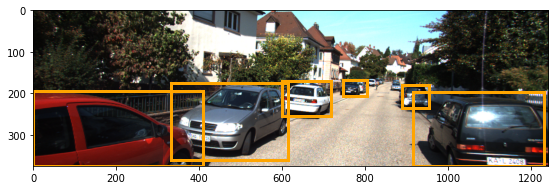

In [60]:
example_filename_2 = '000008.png'
predicted_labels = get_labels(PREDICTION_3D_BOX_DIR)
display_image_2d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename_2),
                      predicted_labels[example_filename_2],
                      force_box_color='orange')
for label in predicted_labels[example_filename_2]:
    print(label)

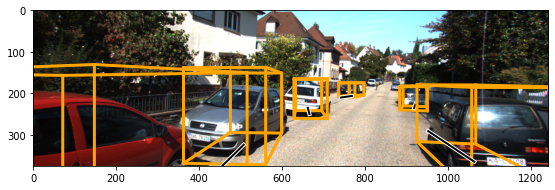

In [58]:
display_image_3d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename_2),
                      predicted_labels[example_filename_2],
                      train_calibrations[example_filename_2],
                      force_box_color='orange')